In [1]:
import random
import os
from typing import NamedTuple

import numpy as np
import torch
import torchvision
from torch.utils import data
from PIL import Image

import model
from tensor_transforms import convert_to_coord_format

In [2]:
class FFHQ256Arguments(NamedTuple):
    """CIPSskip for FFHQ-256"""
    Generator = 'CIPSskip'
    output_dir = 'ffhq256_g_ema.pt'
    out_path = 'checkpoint'
    size = 256
    coords_size = 256
    fc_dim = 512 
    latent = 512
    style_dim = 512
    n_mlp = 8
    activation = None
    channel_multiplier = 2
    ckpt = os.path.join(out_path, output_dir)
    coords_integer_values = False
    path="checkpoint/ffhq256_g_ema.pt"

In [17]:
class FFHQ1024Arguments(NamedTuple):
    """CIPSskip-progressive for FFHQ-1024"""
    Generator = 'CIPSskip'
    output_dir = 'ffhq1024_g_ema.pt'
    out_path = 'checkpoint'
    size = 256
    coords_size = 1024
    fc_dim = 512 
    latent = 512
    style_dim = 512
    n_mlp = 8
    activation = None
    channel_multiplier = 2
    ckpt = os.path.join(out_path, output_dir)
    coords_integer_values = False
    path="checkpoint/ffhq1024_g_ema.pt"

In [2]:
class Churches256Arguments(NamedTuple):
    """CIPSskip for LSUN-Churches-256"""
    Generator = 'CIPSskip'
    output_dir = 'churches_g_ema.pt'
    out_path = 'checkpoint'
    size = 256
    coords_size = 256
    fc_dim = 512 
    latent = 512
    style_dim = 512
    n_mlp = 8
    activation = None
    channel_multiplier = 2
    ckpt = os.path.join(out_path, output_dir)
    coords_integer_values = False
    path="checkpoint/churches_g_ema.pt"

In [2]:
class Lanscapes256Arguments(NamedTuple):
    """CIPSres for Landscapes-256"""
    Generator = 'CIPSres'
    output_dir = 'landscapes_g_ema.pt'
    out_path = 'checkpoint'
    size = 256
    coords_size = 256
    fc_dim = 512 
    latent = 512
    style_dim = 512
    n_mlp = 8
    activation = None
    channel_multiplier = 2
    ckpt = os.path.join(out_path, output_dir)
    coords_integer_values = False
    path="checkpoint/landscapes_g_ema.pt"

In [3]:
args=FFHQ256Arguments()
device = 'cuda'

In [3]:
args=Churches256Arguments()
device='cuda'

In [3]:
args=Lanscapes256Arguments()
device='cuda'

In [4]:
Generator = getattr(model, args.Generator)
g_ema = Generator(size=args.size, hidden_size=args.fc_dim, style_dim=args.latent, n_mlp=args.n_mlp,
                  activation=args.activation, channel_multiplier=args.channel_multiplier,
                  ).to(device)
g_ema.eval();

In [5]:
path=args.path
ckpt = torch.load(path)
g_ema.load_state_dict(ckpt)

<All keys matched successfully>

In [8]:
def get_image(tensor, nrow=2, padding=2,
               normalize=False, range=None, scale_each=False, pad_value=0):
    
    grid = torchvision.utils.make_grid(tensor, nrow=nrow,padding=padding, pad_value=pad_value,
                     normalize=normalize, range=range, scale_each=scale_each)
    ndarr = grid.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()
    im = Image.fromarray(ndarr)
    return im

## Finding mean for truncation trick 

In [9]:
n_sample = 1
sample_z = torch.randn(n_sample, args.latent, device=device)
converted_full = convert_to_coord_format(sample_z.size(0), args.coords_size, args.coords_size, device,
                                         integer_values=args.coords_integer_values)

latents = []
samples = []
with torch.no_grad():
    for _ in range(100):
        sample_z = torch.randn(n_sample, args.latent, device=device)
        sample, latent = g_ema(converted_full, [sample_z], return_latents=True)
        latents.append(latent.cpu())
        samples.append(sample.cpu())

samples = torch.cat(samples, 0)
latents = torch.cat(latents, 0)

truncation_latent = latents.mean(0).cuda()

print('truncation_latent', truncation_latent.shape)
assert len(truncation_latent.shape)==1 and truncation_latent.size(0) == 512, 'smt wrong'

/home/jaepoong/anaconda3/envs/jaepoong/lib/python3.9/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


truncation_latent torch.Size([512])


## Sampling with truncation trick 

In [10]:
n_sample = 8
sample_z = torch.randn(n_sample, args.latent, device=device)
converted_full = convert_to_coord_format(sample_z.size(0), args.coords_size, args.coords_size, device,
                                         integer_values=args.coords_integer_values)
    
print(converted_full)
with torch.no_grad():
    style = g_ema.style(sample_z)
    print(style.size())
    sample, _ = g_ema(converted_full, [style], 
                      truncation=0.6,
                      truncation_latent=truncation_latent,
                      input_is_latent=True,)
    
im = get_image(sample,                        
                nrow=4,
                normalize=True,
                range=(-1, 1),)

im.show()

tensor([[[[-1.0000, -0.9922, -0.9843,  ...,  0.9843,  0.9922,  1.0000],
          [-1.0000, -0.9922, -0.9843,  ...,  0.9843,  0.9922,  1.0000],
          [-1.0000, -0.9922, -0.9843,  ...,  0.9843,  0.9922,  1.0000],
          ...,
          [-1.0000, -0.9922, -0.9843,  ...,  0.9843,  0.9922,  1.0000],
          [-1.0000, -0.9922, -0.9843,  ...,  0.9843,  0.9922,  1.0000],
          [-1.0000, -0.9922, -0.9843,  ...,  0.9843,  0.9922,  1.0000]],

         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9843, -0.9843, -0.9843,  ..., -0.9843, -0.9843, -0.9843],
          ...,
          [ 0.9843,  0.9843,  0.9843,  ...,  0.9843,  0.9843,  0.9843],
          [ 0.9922,  0.9922,  0.9922,  ...,  0.9922,  0.9922,  0.9922],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]]],


        [[[-1.0000, -0.9922, -0.9843,  ...,  0.9843,  0.9922,  1.0000],
          [-1.0000, -0.9922,

/home/jaepoong/anaconda3/envs/jaepoong/lib/python3.9/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


# 좌표 변환 실험.

In [11]:
n_sample = 1
sample_z = torch.randn(n_sample, args.latent, device=device)
converted_full = convert_to_coord_format(sample_z.size(0), args.coords_size, args.coords_size, device,
                                         integer_values=args.coords_integer_values)

    
print(converted_full)
with torch.no_grad():
    style = g_ema.style(sample_z)
    print(style.size())
    sample, _ = g_ema(converted_full, [style], 
                      truncation=0.6,
                      truncation_latent=truncation_latent,
                      input_is_latent=True,)
    
im = get_image(sample,                        
                nrow=int(n_sample ** 0.5),
                normalize=True,
                range=(-1, 1),)

im.show()

tensor([[[[-1.0000, -0.9922, -0.9843,  ...,  0.9843,  0.9922,  1.0000],
          [-1.0000, -0.9922, -0.9843,  ...,  0.9843,  0.9922,  1.0000],
          [-1.0000, -0.9922, -0.9843,  ...,  0.9843,  0.9922,  1.0000],
          ...,
          [-1.0000, -0.9922, -0.9843,  ...,  0.9843,  0.9922,  1.0000],
          [-1.0000, -0.9922, -0.9843,  ...,  0.9843,  0.9922,  1.0000],
          [-1.0000, -0.9922, -0.9843,  ...,  0.9843,  0.9922,  1.0000]],

         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9843, -0.9843, -0.9843,  ..., -0.9843, -0.9843, -0.9843],
          ...,
          [ 0.9843,  0.9843,  0.9843,  ...,  0.9843,  0.9843,  0.9843],
          [ 0.9922,  0.9922,  0.9922,  ...,  0.9922,  0.9922,  0.9922],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]]]],
       device='cuda:0')
torch.Size([1, 512])


# Wandb 코드

In [12]:

import wandb
wandb.init(
    project="CIPS",
    name="Landscape-256 pretrained generating",
)
example=[]
n_sample=8
for iter in range(100):
    sample_z = torch.randn(n_sample, args.latent, device=device)
    converted_full = convert_to_coord_format(sample_z.size(0), args.coords_size, args.coords_size, device,
                                         integer_values=args.coords_integer_values)

    with torch.no_grad():
        style = g_ema.style(sample_z)
        print(style.size())
        sample, _ = g_ema(converted_full, [style], 
                        truncation=0.6,
                        truncation_latent=truncation_latent,
                        input_is_latent=True,)
        
        im = get_image(sample,                        
                        nrow=4,
                        normalize=True,
                        range=(-1, 1),)
        image=wandb.Image(im,caption=f"iter{iter}")
        example.append(image)
wandb.log({"examples":example})
wandb.finish()
    
    

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: poong2 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.21 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


torch.Size([8, 512])


/home/jaepoong/anaconda3/envs/jaepoong/lib/python3.9/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/jaepoong/anaconda3/envs/jaepoong/lib/python3.9/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8

In [15]:
import wandb
from tensor_transforms import convert_to_dif_coord_format
wandb.init(
    project="CIPS",
    name="Landscape-512 [-1.0,1.0][-1.0,1.0]",
)
example=[]
n_sample=2
for iter in range(100):
    sample_z = torch.randn(n_sample, args.latent, device=device)
    converted_full = convert_to_dif_coord_format(sample_z.size(0), 512, 512, device=device,
                h_range=(-1.0,1.0),w_range=(-1.0,1.0))

    with torch.no_grad():
        style = g_ema.style(sample_z)
        print(style.size())
        sample, _ = g_ema(converted_full, [style], 
                        truncation=1,
                        truncation_latent=None,
                        input_is_latent=True,)
        
        im = get_image(sample,                        
                        nrow=1,
                        normalize=True,
                        range=(-1, 1),)
        image=wandb.Image(im,caption=f"iter{iter}")
        example.append(image)
wandb.log({"examples":example})

wandb: wandb version 0.12.21 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


torch.Size([2, 512])


/home/jaepoong/anaconda3/envs/jaepoong/lib/python3.9/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/jaepoong/anaconda3/envs/jaepoong/lib/python3.9/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2

# PCA

In [16]:
emb_np=g_ema.emb.input.squeeze(0).permute(1,2,0).detach().cpu().numpy()
result=[]
emb_np=emb_np.reshape(256*256,-1)
emb_np.shape

(65536, 512)

In [17]:
from sklearn.decomposition import PCA
pca=PCA(n_components=3)
pca.fit(emb_np)
df=pca.transform(emb_np)
df.shape


(65536, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


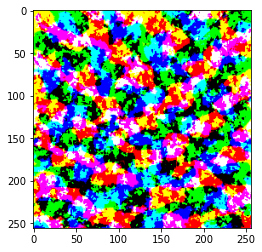

wandb: Network error (ReadTimeout), entering retry loop.


In [25]:
import matplotlib.pyplot as plt
im=df.reshape(256,256,3)
imx=im[:,:,:]
plt.imshow(imx)